In [26]:
import pandas
import os
import csv
import sys
import datetime
import numpy as np
from io import StringIO
import cProfile
import pandas_ta as ta
from matplotlib import pyplot as plt

PATH_TILL_PRISER = "C:\\Users\\antasp23\\Documents\\Programmering\\Gymnasiearbete\\aktiepriser"

In [23]:
def find_intersects(s0: pandas.Series, s1: pandas.Series):
    """
    Finds intersects between two pandas series.
    returns a dict of time and type of intersection of all intersections
    """

    intersects = {}
    # Find biggest series and use that one
    long = pandas.Series()
    short = pandas.Series()
    if s0.size >= s1.size:
        long = s0
        short = s1
    else:
        long = s1
        short = s0

	# p is for price
    prev_p0 = 0
    prev_p1 = 0

    for time in long.to_dict().keys():
        p0 = long[time]
        p1 = short[time]
        if np.isnan(p0) or np.isnan(p1):
            continue
        if p0 > p1 and prev_p0 < prev_p1:
            intersects[time] = "under"
        elif p0 < p1 and prev_p0 > prev_p1:
            intersects[time] = "over"

        prev_p0 = p0
        prev_p1 = p1

    return intersects


In [ ]:
class EMABot():
    def __init__(self, bot_namn:str, tickers:list[str], risk:float=0.02, short_period:int=9, long_period:int=21):
        self.bot_namn = bot_namn
        self.tickers = tickers
        self.short_period = short_period
        self.long_period = long_period
    
    def _retrieve_data(self):
        """Retrieves latest data from all stocks defined in tickers.
        Amount of data is `self.long_period` amount of minutes going backwards from last minute"""
        dataframes = {}
        for t in self.tickers:
            df = pandas.DataFrame(columns=["TIME","PRICE","CHANGE_PERCENT","CHANGE"])
            
            price_path = os.path.join(PATH_TILL_PRISER, f"{t}.csv")
            if not os.path.isfile(price_path):
                print("Couldn't find file:", price_path)
                continue
            
            # Iteratively read the end of the file to get enough data for the long_period EMA.
            # This is memory-efficient and handles variable data frequency.
            try:
                chunk_size = 1024 * 16  # Start with 16KB
                df = pandas.DataFrame()

                with open(price_path, 'rb') as f:
                    f.seek(0, os.SEEK_END)
                    file_size = f.tell()

                    while True:
                        read_pos = max(0, file_size - chunk_size)
                        f.seek(read_pos)
                        
                        # Read and decode the chunk
                        tail_data = f.read().decode('utf-8')
                        
                        # If we didn't start at the beginning, the first line might be partial, so we skip it.
                        if read_pos > 0:
                            first_newline = tail_data.find('\n')
                            if first_newline != -1:
                                tail_data = tail_data[first_newline + 1:]

                        # Create a DataFrame from the chunk
                        df = pandas.read_csv(StringIO(tail_data), names=["TIME", "PRICE", "CHANGE_PERCENT", "CHANGE"], header=None if read_pos > 0 else 0)
                        
                        # Check if we have enough data
                        df['TIME'] = pandas.to_datetime(df['TIME'], format="%H:%M:%S", errors="coerce").dt.time
                        df.dropna(subset=['TIME'], inplace=True)

                        if df.empty: # If chunk is empty or all times are invalid
                            if read_pos == 0: break # Reached start of file
                            chunk_size *= 2 # Read more data
                            continue

                        latest_time = pandas.Timestamp.combine(pandas.Timestamp.today().date(), df['TIME'].iloc[-1])
                        earliest_needed = latest_time - pandas.Timedelta(minutes=self.long_period)
                        earliest_in_df = pandas.Timestamp.combine(pandas.Timestamp.today().date(), df['TIME'].iloc[0])

                        if earliest_in_df <= earliest_needed or read_pos == 0:
                            break # We have enough data or have read the whole file
                        
                        chunk_size *= 2 # Not enough data, double the chunk size and retry
            except (IOError, FileNotFoundError, IndexError) as e:
                print(f"Error reading or processing {price_path}: {e}")
                continue

            df['TIME'] = pandas.to_datetime(df['TIME'], format="%H:%M:%S", errors="coerce")
            df['PRICE'] = pandas.to_numeric(df['PRICE'], errors='coerce')
            df = df.resample("1min", on='TIME').mean()
            dataframes[t] = df

        return dataframes
    
    def find_options(self):
        price_data = self._retrieve_data()
        suggestions = {}
        for (t, df) in price_data.items():
            ema_short = ta.ema(df['PRICE'], self.short_period)
            ema_long = ta.ema(df['PRICE'], self.long_period)
            
            intersects = find_intersects(ema_short, ema_long)
            print(intersects)
            plt.plot(df['PRICE'])
            plt.plot(ema_short)
            plt.plot(ema_long)
            plt.show()


{Timestamp('1900-01-01 11:46:00'): 'under', Timestamp('1900-01-01 11:53:00'): 'over', Timestamp('1900-01-01 12:04:00'): 'under'}


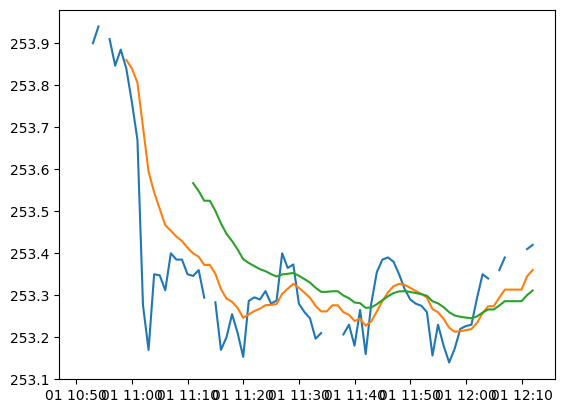

{Timestamp('1900-01-01 12:12:00'): 'under'}


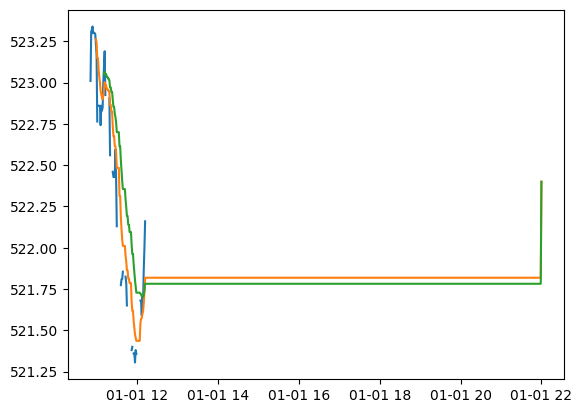

         435295 function calls (423999 primitive calls) in 1.016 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.001    0.001    0.047    0.047 2064733047.py:8(_retrieve_data)
        2    0.004    0.002    0.041    0.020 3585007689.py:1(find_intersects)
       17    0.000    0.000    0.000    0.000 <frozen _collections_abc>:108(_check_methods)
        1    0.000    0.000    0.000    0.000 <frozen _collections_abc>:292(__subclasshook__)
       25    0.000    0.000    0.000    0.000 <frozen _collections_abc>:313(__subclasshook__)
       19    0.000    0.000    0.000    0.000 <frozen _collections_abc>:345(__subclasshook__)
        5    0.000    0.000    0.000    0.000 <frozen _collections_abc>:392(__subclasshook__)
        3    0.000    0.000    0.000    0.000 <frozen _collections_abc>:411(__subclasshook__)
       89    0.000    0.000    0.000    0.000 <frozen _collections_abc>:439(__subclasshook__)
       12  

In [29]:
bot = EMABot("test", ["AAPL", "MSFT"])
cProfile.run("bot.find_options()")